In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import Cityscapes
from PIL import Image
import os
import numpy as np
import torchmetrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [2]:
NUM_CLASSES = 28+1 #including background-class
MODEL_PATH = 'model_1000_epoch.pth'
DEVICE = 'cuda'
NUM_EPOCHS = 1000
BATCH_SIZE = 16

In [3]:
model = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(num_classes=NUM_CLASSES)
device = torch.device(DEVICE if torch.cuda.is_available() else 'cpu')
model = model.to(device)
try:
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
except FileNotFoundError:
    pass

class ModelCheckpoint:
    def __init__(self, file_path):
        self.file_path = file_path
        self.best_loss = float('inf')
    
    def __call__(self, epoch, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            torch.save(model.state_dict(), self.file_path)

checkpoint = ModelCheckpoint(MODEL_PATH)

In [4]:
class CustomDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)
        self.masks = os.listdir(mask_dir)

    def __len__(self):
        return len(self.masks)

    def __getitem__(self, idx):
        
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        image_path = os.path.join(self.image_dir, self.masks[idx]) 

        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')
        
        
        if self.transform:
            transformed = self.transform(image=np.asarray(image).copy(), mask=np.asarray(mask).copy())
            image = transformed["image"]
            mask = transformed["mask"]
            
        return image, mask

In [5]:
train_transform = A.Compose([
    A.Resize(height=512, width=512),
    A.HorizontalFlip(),
    A.Rotate(limit=10),
    A.ColorJitter(),
    A.Normalize(),
    ToTensorV2(),
])


loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [6]:
image_folder = 'data/resized/images/'
mask_folder = 'data/resized/masks/'

dataset = CustomDataset(image_folder, mask_folder, transform=train_transform)

train_dataset, test_val_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
val_dataset, test_dataset = train_test_split(test_val_dataset, test_size=0.5, random_state=42)



train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=4)

In [7]:
def calc_jaccard_score(preds, masks):
    jaccard_score = torchmetrics.JaccardIndex(task="multiclass", 
                                                  num_classes=NUM_CLASSES, 
                                                  ignore_index=0).to(device)
    return jaccard_score(preds, torch.squeeze(masks, dim=1))


def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.
    epoch_iou = 0.
    
    for i, (images, masks) in enumerate(train_dataloader):
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)['out']
        preds = torch.argmax(outputs, dim=1)
        
        epoch_iou += calc_jaccard_score(preds, masks)
        loss_value = loss(outputs, masks.squeeze(1).long())
        loss_value.backward()
        
        optimizer.step()
        running_loss += loss_value
    
    last_loss = running_loss / len(train_dataloader)
    epoch_iou /= len(train_dataloader)
    return last_loss, epoch_iou


def val_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.
    val_epoch_iou = 0.
    
    with torch.no_grad():
        for images, masks in val_dataloader:
            
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)['out']
            preds = torch.argmax(outputs, dim=1)
            
            loss_value = loss(outputs, masks.squeeze(1).long())
            running_loss += loss_value
            
            val_epoch_iou += calc_jaccard_score(preds, masks)
    
    last_loss = running_loss / len(train_dataloader)
    val_epoch_iou /= len(val_dataloader)
    return last_loss, val_epoch_iou

In [ ]:
check_time = True
start_time = None

for epoch in range(NUM_EPOCHS):
    
    if check_time:
        start = time.time()
        check_time = False


    model.train()
    loss_value, epoch_iou = train_one_epoch(epoch)
    
    if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch+1}/{NUM_EPOCHS}')
        print(f'\n==Train values==\nLoss: {"{:.3f}".format(loss_value)} IoU: {"{:.3f}".format(epoch_iou)}')
        
    
    model.eval()
    val_loss, val_epoch_iou = val_one_epoch(epoch)
    
    if (epoch + 1) % 5 == 0:
        print(f'==Val values== \nLoss: {"{:.3f}".format(val_loss)} IoU: {"{:.3f}".format(val_epoch_iou)}')
        
        end = time.time()
        check_time = True
        print(end - start, "seconds per 5 epoch")
        print('=='*20)
    
    checkpoint(epoch + 1, val_loss)
    
    if (epoch+1) % 100 == 0:
        time.sleep(300)  

Epoch 5/1000

==Train values==
Loss: 0.088 IoU: 0.083
==Val values== 
Loss: 0.013 IoU: 0.041
75.90815377235413 seconds per 5 epoch
Epoch 10/1000

==Train values==
Loss: 0.049 IoU: 0.131
==Val values== 
Loss: 0.014 IoU: 0.041
76.20725393295288 seconds per 5 epoch
Epoch 15/1000

==Train values==
Loss: 0.040 IoU: 0.156
==Val values== 
Loss: 0.014 IoU: 0.036
75.20939445495605 seconds per 5 epoch
Epoch 20/1000

==Train values==
Loss: 0.024 IoU: 0.199
==Val values== 
Loss: 0.012 IoU: 0.062
75.21760368347168 seconds per 5 epoch
Epoch 25/1000

==Train values==
Loss: 0.017 IoU: 0.238
==Val values== 
Loss: 0.014 IoU: 0.058
75.17389392852783 seconds per 5 epoch
Epoch 30/1000

==Train values==
Loss: 0.016 IoU: 0.241
==Val values== 
Loss: 0.014 IoU: 0.058
75.23087859153748 seconds per 5 epoch
Epoch 35/1000

==Train values==
Loss: 0.013 IoU: 0.262
==Val values== 
Loss: 0.016 IoU: 0.053
75.25324940681458 seconds per 5 epoch
Epoch 40/1000

==Train values==
Loss: 0.028 IoU: 0.224
==Val values== 
Loss: 

==Val values== 
Loss: 0.024 IoU: 0.052
75.07276821136475 seconds per 5 epoch
Epoch 245/1000

==Train values==
Loss: 0.006 IoU: 0.314
==Val values== 
Loss: 0.023 IoU: 0.052
75.0932297706604 seconds per 5 epoch
Epoch 250/1000

==Train values==
Loss: 0.006 IoU: 0.319
==Val values== 
Loss: 0.025 IoU: 0.054
75.12637162208557 seconds per 5 epoch
Epoch 255/1000

==Train values==
Loss: 0.006 IoU: 0.318
==Val values== 
Loss: 0.024 IoU: 0.051
75.08553051948547 seconds per 5 epoch
Epoch 260/1000

==Train values==
Loss: 0.006 IoU: 0.321
==Val values== 
Loss: 0.027 IoU: 0.050
75.10057020187378 seconds per 5 epoch
Epoch 265/1000

==Train values==
Loss: 0.006 IoU: 0.325
==Val values== 
Loss: 0.030 IoU: 0.057
75.08832597732544 seconds per 5 epoch
Epoch 270/1000

==Train values==
Loss: 0.006 IoU: 0.321
==Val values== 
Loss: 0.026 IoU: 0.048
75.11251544952393 seconds per 5 epoch
Epoch 275/1000

==Train values==
Loss: 0.039 IoU: 0.181
==Val values== 
Loss: 0.016 IoU: 0.047
75.05694317817688 seconds per 5

Epoch 480/1000

==Train values==
Loss: 0.007 IoU: 0.309
==Val values== 
Loss: 0.024 IoU: 0.051
75.15273857116699 seconds per 5 epoch
Epoch 485/1000

==Train values==
Loss: 0.006 IoU: 0.321
==Val values== 
Loss: 0.027 IoU: 0.043
75.10144901275635 seconds per 5 epoch
Epoch 490/1000

==Train values==
Loss: 0.005 IoU: 0.324
==Val values== 
Loss: 0.032 IoU: 0.052
75.094562292099 seconds per 5 epoch
Epoch 495/1000

==Train values==
Loss: 0.005 IoU: 0.331
==Val values== 
Loss: 0.029 IoU: 0.060
75.1110360622406 seconds per 5 epoch
Epoch 500/1000

==Train values==
Loss: 0.005 IoU: 0.332
==Val values== 
Loss: 0.029 IoU: 0.050
75.1324577331543 seconds per 5 epoch
Epoch 505/1000

==Train values==
Loss: 0.005 IoU: 0.338
==Val values== 
Loss: 0.030 IoU: 0.053
74.91471672058105 seconds per 5 epoch
Epoch 510/1000

==Train values==
Loss: 0.005 IoU: 0.329
==Val values== 
Loss: 0.033 IoU: 0.058
75.03454065322876 seconds per 5 epoch
Epoch 515/1000

==Train values==
Loss: 0.005 IoU: 0.332
==Val values== 
L

==Val values== 
Loss: 0.039 IoU: 0.049
75.09106755256653 seconds per 5 epoch
Epoch 720/1000

==Train values==
Loss: 0.004 IoU: 0.337
==Val values== 
Loss: 0.041 IoU: 0.052
75.03905391693115 seconds per 5 epoch
Epoch 725/1000

==Train values==
Loss: 0.004 IoU: 0.338
==Val values== 
Loss: 0.041 IoU: 0.048
75.09022212028503 seconds per 5 epoch
Epoch 730/1000

==Train values==
Loss: 0.004 IoU: 0.340
==Val values== 
Loss: 0.043 IoU: 0.053
75.04992771148682 seconds per 5 epoch
Epoch 735/1000

==Train values==
Loss: 0.004 IoU: 0.338
==Val values== 
Loss: 0.040 IoU: 0.044
75.16155695915222 seconds per 5 epoch
Epoch 740/1000

==Train values==
Loss: 0.004 IoU: 0.340
==Val values== 
Loss: 0.043 IoU: 0.044
75.11405992507935 seconds per 5 epoch
Epoch 745/1000

==Train values==
Loss: 0.019 IoU: 0.243
==Val values== 
Loss: 0.023 IoU: 0.038
75.00724959373474 seconds per 5 epoch
Epoch 750/1000

==Train values==
Loss: 0.006 IoU: 0.323
==Val values== 
Loss: 0.032 IoU: 0.044
75.07766222953796 seconds per 

Epoch 955/1000

==Train values==
Loss: 0.004 IoU: 0.341
==Val values== 
Loss: 0.043 IoU: 0.044
75.19514846801758 seconds per 5 epoch
Epoch 960/1000

==Train values==
Loss: 0.004 IoU: 0.339
==Val values== 
Loss: 0.045 IoU: 0.048
75.16911840438843 seconds per 5 epoch
Epoch 965/1000

==Train values==
Loss: 0.004 IoU: 0.347
==Val values== 
Loss: 0.047 IoU: 0.058
75.20892024040222 seconds per 5 epoch
Epoch 970/1000

==Train values==
Loss: 0.004 IoU: 0.339
==Val values== 
Loss: 0.047 IoU: 0.050
75.26824259757996 seconds per 5 epoch
Epoch 975/1000

==Train values==
Loss: 0.005 IoU: 0.331
==Val values== 
Loss: 0.033 IoU: 0.048
75.20415925979614 seconds per 5 epoch
Epoch 980/1000

==Train values==
Loss: 0.004 IoU: 0.337
==Val values== 
Loss: 0.048 IoU: 0.043
75.19871759414673 seconds per 5 epoch
Epoch 985/1000

==Train values==
Loss: 0.004 IoU: 0.344
==Val values== 
Loss: 0.044 IoU: 0.049
75.12968564033508 seconds per 5 epoch
Epoch 990/1000

==Train values==
Loss: 0.004 IoU: 0.333
==Val values=

In [17]:
model.eval()

example_of_preds = []
with torch.no_grad():
    epoch_iou = 0
    for epoch, (images, masks) in enumerate(test_dataloader):
        images = images.to(device)
        masks = masks.to(device)
        
        outputs = model(images)['out']
        preds = torch.argmax(outputs, dim=1)

        epoch_iou += calc_jaccard_score(preds, masks)

        if epoch > len(test_dataloader) - 5:
            images = torch.squeeze(images, dim=0).cpu().numpy().transpose(1, 2, 0)
            preds_image = preds.cpu().numpy().transpose(1, 2, 0)
            mask_image = torch.squeeze(masks, dim=0).cpu().numpy()
            example_of_preds.append([images, preds_image, mask_image])

    epoch_iou /= len(test_dataloader)
    print(f'IoU: {epoch_iou}')

IoU: 0.009559147991240025


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


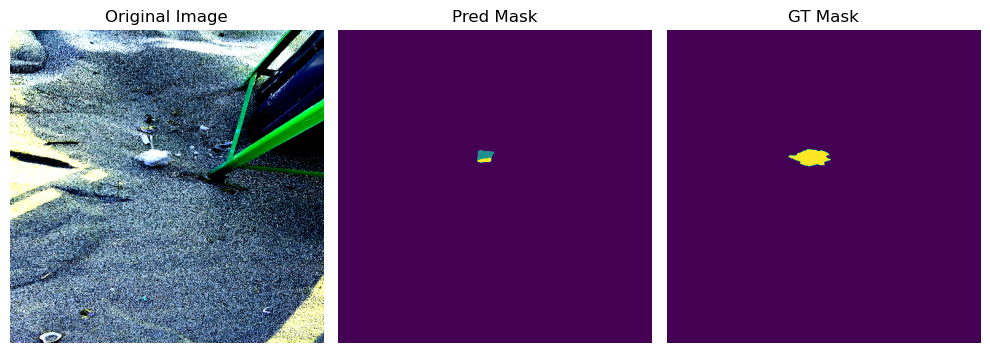

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


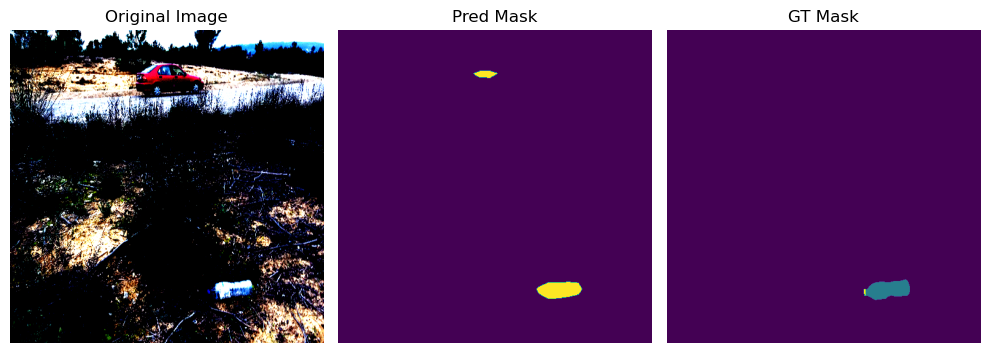

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


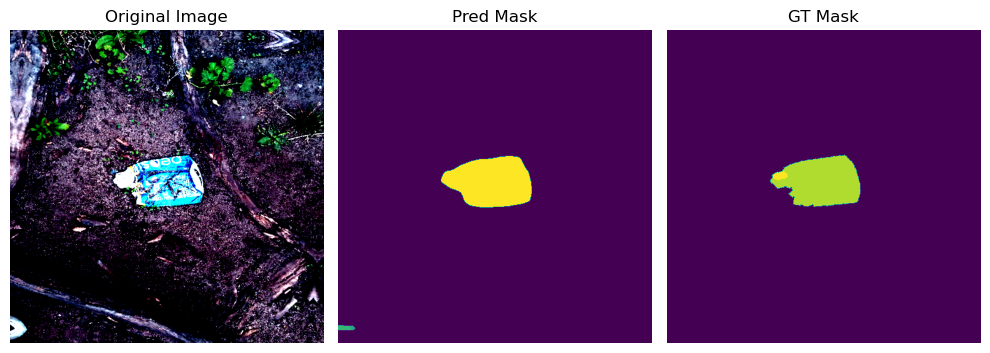

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


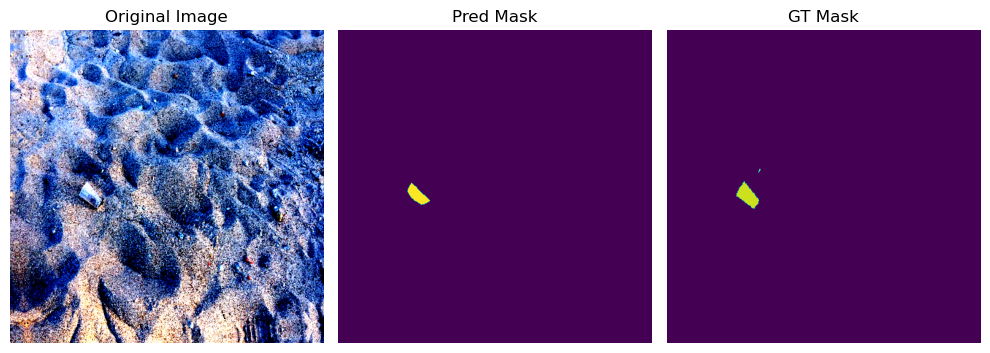

In [18]:
for images, preds_image, mask_image in example_of_preds:
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    axes[0].imshow(images)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(preds_image)
    axes[1].set_title('Pred Mask')
    axes[1].axis('off')

    axes[2].imshow(mask_image)
    axes[2].set_title('GT Mask')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()